In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/MLG_Project_Code')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math
from math import sqrt
import torchvision
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
!pip install reformer-pytorch

In [ ]:
def load_data(split_type):
  data = torch.load(f'processed/{split_type}.pt')
  return data

In [ ]:
train_data = load_data('train')
val_data = load_data('val')
test_data = load_data('test')

In [ ]:
train_data[0]

In [ ]:
val_data[0]

In [ ]:
test_data[0]

##Transform Loaded Data to Required Format

In [ ]:
def format_data_for_tpatch(timestamps_raw, values_raw, mask_raw, N_dim, L_seq, L_in, L_p):
    """
    Transforms raw sequential patient data into the patched format required by tPatchGNN.

    Args:
        timestamps_raw (torch.Tensor): (T,) Normalized timestamps.
        values_raw (torch.Tensor): (T, N) Z-score normalized values.
        mask_raw (torch.Tensor): (T, N) Observation mask (1=observed, 0=missing).
        N_dim (int): Number of dimensions/variables (e.g., 41 for PhysioNet).
        L_seq (int): Input historical sequence length (must be L_in * M).
        L_in (int): Length of each patch.
        L_p (int): Prediction length (number of future time steps to predict).

    Returns:
        tuple: (X, truth_time_steps, mask, time_steps_to_predict)
    """
    if values_raw.dim() == 1:
        # If the shape is (T,), unsqueeze to (T, 1) and expand to (T, N_dim).
        values_raw = values_raw.unsqueeze(-1).expand(-1, N_dim)

    if mask_raw.dim() == 1:
        # Mask must match shape of values.
        mask_raw = mask_raw.unsqueeze(-1).expand(-1, N_dim)

    T, N = values_raw.shape
    M = L_seq // L_in # Number of patches

    # 1. Truncate/Pad the Historical Sequence to L_seq
    if T > L_seq:
        # Truncate to the last L_seq observations
        hist_timestamps = timestamps_raw[-L_seq:]
        hist_values = values_raw[-L_seq:]
        hist_mask = mask_raw[-L_seq:]
    elif T < L_seq:
        # Pad with zeros/appropriate values if the sequence is shorter
        padding_len = L_seq - T
        pad_val = torch.zeros((padding_len, N), dtype=values_raw.dtype)
        pad_mask = torch.zeros((padding_len, N), dtype=mask_raw.dtype)

        hist_values = torch.cat([pad_val, values_raw], dim=0)
        hist_mask = torch.cat([pad_mask, mask_raw], dim=0)

        # NOTE: Timestamp padding is more complex. For simplicity, we pad time
        # with the minimum historical time to ensure all are in [0,1]
        pad_time = torch.full((padding_len,), timestamps_raw[0].item(), dtype=timestamps_raw.dtype)
        hist_timestamps = torch.cat([pad_time, timestamps_raw], dim=0)
    else: # T == L_seq
        hist_timestamps = timestamps_raw
        hist_values = values_raw
        hist_mask = mask_raw


    # --- Tensors for Historical Input ---

    # Required shape: (M, L_in, N)

    # 2. X (Values) and mask
    X = hist_values.reshape(M, L_in, N)
    mask = hist_mask.reshape(M, L_in, N)

    # 3. truth_time_steps (Timestamps)
    # The model expects timestamps to be broadcast across the N dimension
    # (L_seq) -> (L_seq, N) -> (M, L_in, N)
    truth_time_steps = hist_timestamps.unsqueeze(-1).repeat(1, N) # (L_seq, N)
    truth_time_steps = truth_time_steps.reshape(M, L_in, N)

    # --- Tensor for Prediction Target Time Steps ---

    # 4. time_steps_to_predict
    # Required shape: (L_p)
    # This must be the normalized timestamps of the future time steps.
    # Here we simulate by assuming a constant interval from the last historical time.

    last_time = hist_timestamps[-1].item()
    # Assuming an average time interval (e.g., based on your EDA mean interval of 0.64 hr)
    # NOTE: The actual delta depends on your data's sampling rate.
    simulated_delta = 0.01 # Example normalized time delta

    future_times = torch.arange(1, L_p + 1) * simulated_delta + last_time
    time_steps_to_predict = future_times.float()

    return X, truth_time_steps, mask, time_steps_to_predict

In [ ]:
# Example Usage

# Hyperparameters
N_DIM = 41          # Number of variables/dimensions (from DATA_PREPROCESSING.md)
L_SEQ = 64          # Input sequence length (L_seq = M * L_in)
L_IN = 8            # Patch length
L_P = 12            # Prediction length
M_PATCHES = L_SEQ // L_IN # M = 8

# Simulate loading a single patient's raw data (T=64)
# Patient sequence length is T_sample, which may not be L_SEQ
T_SAMPLE = 64

# (T_SAMPLE,) normalized timestamps
timestamps_sim = torch.linspace(0.0, 0.5, T_SAMPLE)
# (T_SAMPLE, N_DIM) values
values_sim = torch.randn(T_SAMPLE, N_DIM)
# (T_SAMPLE, N_DIM) mask
mask_sim = torch.randint(0, 2, (T_SAMPLE, N_DIM)).float()

X, truth_time_steps, mask, time_steps_to_predict = format_data_for_tpatch(
    timestamps_sim, values_sim, mask_sim, N_DIM, L_SEQ, L_IN, L_P
)

# 5. Add the Batch Dimension (B)
# For a single sample, B=1. You would loop through your dataset to create a batch.
B = 1
X = X.unsqueeze(0)
truth_time_steps = truth_time_steps.unsqueeze(0)
mask = mask.unsqueeze(0)
time_steps_to_predict = time_steps_to_predict.unsqueeze(0)

print(f"--- Required Shapes for tPatchGNN ---")
print(f"X (Values): {tuple(X.shape)}")
print(f"truth_time_steps (Timestamps): {tuple(truth_time_steps.shape)}")
print(f"mask (Observation Mask): {tuple(mask.shape)}")
print(f"time_steps_to_predict (Future Times): {tuple(time_steps_to_predict.shape)}")

In [ ]:
class TpatchDataset(Dataset):
    def __init__(self, raw_data, N_dim, L_seq, L_in, L_p):
        """
        raw_data: list of tuples (timestamps, values, mask, target_values, target_mask)
        """
        self.raw_data = raw_data
        self.N_dim = N_dim
        self.L_seq = L_seq
        self.L_in = L_in
        self.L_p = L_p

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        # 1. Unpack Raw Data (Assuming: ID, Timestamps, Values, Mask)
        data_tuple = self.raw_data[idx]
        record_id = data_tuple[0]
        timestamps_raw = data_tuple[1]
        values_raw = data_tuple[2]
        mask_raw = data_tuple[3]

        # Define fixed slicing bounds using L_SEQ and L_P
        hist_end_idx = self.L_seq
        target_end_idx = self.L_seq + self.L_p

        # --- Slicing Historical Input (Corresponds to 0-24hr) ---
        hist_timestamps = timestamps_raw[:hist_end_idx]
        hist_values = values_raw[:hist_end_idx]
        hist_mask = mask_raw[:hist_end_idx]

        # --- Slicing Forecast Targets (Corresponds to the next 6-24hr) ---
        # This slices the ground truth for the prediction window.
        forecast_tgt = values_raw[hist_end_idx : target_end_idx]
        forecast_mask = mask_raw[hist_end_idx : target_end_idx]
        time_steps_to_predict = timestamps_raw[hist_end_idx : target_end_idx] # The true future time steps

        # 2. Process Historical Data via format_data_for_tpatch
        X, truth_time_steps, mask_hist, time_steps_to_predict_sim = format_data_for_tpatch(
            hist_timestamps, hist_values, hist_mask, self.N_dim, self.L_seq, self.L_in, self.L_p
        )

        # 3. Handle Target Padding (If the raw sequence is too short, pad the target)
        if forecast_tgt.shape[0] < self.L_p:
            pad_len = self.L_p - forecast_tgt.shape[0]
            pad_val = torch.zeros((pad_len, self.N_dim), dtype=values_raw.dtype)

            forecast_tgt = torch.cat([forecast_tgt, pad_val], dim=0)
            forecast_mask = torch.cat([forecast_mask, pad_val], dim=0)

            # Use the simulated time steps (time_steps_to_predict_sim) for the prediction header
            time_steps_to_predict = time_steps_to_predict_sim

        # If the slice was successful (len >= L_P), ensure the time steps array is exactly L_P.
        else:
            time_steps_to_predict = time_steps_to_predict[:self.L_p]

        # 4. Assemble final output
        hist_data = (X, truth_time_steps, mask_hist, time_steps_to_predict)

        return hist_data, self.L_seq, forecast_tgt, forecast_mask

In [ ]:
# Create Datasets
train_dataset = TpatchDataset(train_data, N_DIM, L_SEQ, L_IN, L_P)
val_dataset = TpatchDataset(val_data, N_DIM, L_SEQ, L_IN, L_P)
test_dataset = TpatchDataset(test_data, N_DIM, L_SEQ, L_IN, L_P)

# Define Collate Function
# Since hist_data is a tuple, a collate function batches the elements inside the tuple
def tpatch_collate_fn(batch):
    # 'batch' is a list of (hist_data_tuple, hist_len, forecast_tgt, forecast_mask)
    hist_datas, hist_lens, forecast_tgts, forecast_masks = zip(*batch)

    # hist_datas is a list of tuples: [(X, truth_time_steps, mask_hist, time_steps_to_predict), ...]
    # Zip again to separate the elements of hist_data_tuple
    X_batch, time_steps_batch, mask_hist_batch, time_steps_pred_batch = zip(*hist_datas)

    # Stack the historical data components (all should have shape (B, M, L_in, N))
    X_batch = torch.stack(X_batch)
    time_steps_batch = torch.stack(time_steps_batch)
    mask_hist_batch = torch.stack(mask_hist_batch)

    # Stack the prediction time steps (shape (B, L_p))
    time_steps_pred_batch = torch.stack(time_steps_pred_batch)

    # Stack the target and mask (shape (B, L_p, N))
    forecast_tgts_batch = torch.stack(forecast_tgts)
    forecast_masks_batch = torch.stack(forecast_masks)

    # The hist_len is fixed L_SEQ, so we just pass one value or a list if needed
    hist_len_batch = torch.tensor(hist_lens[0])

    # hist_data becomes a tuple of batched tensors
    hist_data_batch = (X_batch, time_steps_batch, mask_hist_batch, time_steps_pred_batch)

    return hist_data_batch, hist_len_batch, forecast_tgts_batch, forecast_masks_batch

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=tpatch_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=tpatch_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=tpatch_collate_fn)

## Load model code

### Subtask:
Load the Python code from `/content/drive/MyDrive/MLG_Project_Code/src/models/tPatch/model` into a code cell in the notebook.


In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=2,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1, 2)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)

class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x


In [ ]:
class DSAttention(nn.Module):
    '''De-stationary Attention'''

    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(DSAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        tau = 1.0 if tau is None else tau.unsqueeze(
            1).unsqueeze(1)  # B x 1 x 1 x 1
        delta = 0.0 if delta is None else delta.unsqueeze(
            1).unsqueeze(1)  # B x 1 x 1 x S

        # De-stationary Attention, rescaling pre-softmax score with learned de-stationary factors
        scores = torch.einsum("blhe,bshe->bhls", queries, keys) * tau + delta

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None

class FullAttention(nn.Module):
    def __init__(self, mask_flag=False, factor=3, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None

class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top):  # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        # real U = U_part(factor*ln(L_k))*L_q
        index_sample = torch.randint(L_K, (L_Q, sample_k))
        K_sample = K_expand[:, :, torch.arange(
            L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(
            Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze()

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   M_top, :]  # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))  # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H,
                                                L_Q, V_sum.shape[-1]).clone()
        else:  # use mask
            # requires that L_Q == L_V, i.e. for self-attention only
            assert (L_Q == L_V)
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1)  # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
        torch.arange(H)[None, :, None],
        index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V]) /
                     L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[
                                                  None, :, None], index, :] = attn
            return context_in, attns
        else:
            return context_in, None

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)

        U_part = self.factor * \
                 np.ceil(np.log(L_K)).astype('int').item()  # c*ln(L_k)
        u = self.factor * \
            np.ceil(np.log(L_Q)).astype('int').item()  # c*ln(L_q)

        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q

        scores_top, index = self._prob_QK(
            queries, keys, sample_k=U_part, n_top=u)

        # add scale factor
        scale = self.scale or 1. / sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(
            context, values, scores_top, index, L_Q, attn_mask)

        return context.contiguous(), attn

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask=None, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

class ReformerLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None, causal=False, bucket_size=4, n_hashes=4):
        super().__init__()
        self.bucket_size = bucket_size
        self.attn = LSHSelfAttention(
            dim=d_model,
            heads=n_heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=causal
        )

    def fit_length(self, queries):
        # inside reformer: assert N % (bucket_size * 2) == 0
        B, N, C = queries.shape
        if N % (self.bucket_size * 2) == 0:
            return queries
        else:
            # fill the time series
            fill_len = (self.bucket_size * 2) - (N % (self.bucket_size * 2))
            return torch.cat([queries, torch.zeros([B, fill_len, C]).to(queries.device)], dim=1)

    def forward(self, queries, keys, values, attn_mask, tau, delta):
        # in Reformer: defalut queries=keys
        B, N, C = queries.shape
        queries = self.attn(self.fit_length(queries))[:, :N, :]
        return queries, None

class TwoStageAttentionLayer(nn.Module):
    '''
    The Two Stage Attention (TSA) Layer
    input/output shape: [batch_size, Data_dim(D), Seg_num(L), d_model]
    '''

    def __init__(self, configs,
                 seg_num, factor, d_model, n_heads, d_ff=None, dropout=0.1):
        super(TwoStageAttentionLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.time_attention = AttentionLayer(FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                                           output_attention=configs.output_attention), d_model, n_heads)
        self.dim_sender = AttentionLayer(FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                                       output_attention=configs.output_attention), d_model, n_heads)
        self.dim_receiver = AttentionLayer(FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                                         output_attention=configs.output_attention), d_model, n_heads)
        self.router = nn.Parameter(torch.randn(seg_num, factor, d_model))

        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff),
                                  nn.GELU(),
                                  nn.Linear(d_ff, d_model))
        self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff),
                                  nn.GELU(),
                                  nn.Linear(d_ff, d_model))

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # Cross Time Stage: Directly apply MSA to each dimension
        batch = x.shape[0]
        time_in = rearrange(x, 'b ts_d seg_num d_model -> (b ts_d) seg_num d_model')
        time_enc, attn = self.time_attention(
            time_in, time_in, time_in, attn_mask=None, tau=None, delta=None
        )
        dim_in = time_in + self.dropout(time_enc)
        dim_in = self.norm1(dim_in)
        dim_in = dim_in + self.dropout(self.MLP1(dim_in))
        dim_in = self.norm2(dim_in)

        # Cross Dimension Stage: use a small set of learnable vectors to aggregate and distribute messages to build the D-to-D connection
        dim_send = rearrange(dim_in, '(b ts_d) seg_num d_model -> (b seg_num) ts_d d_model', b=batch)
        batch_router = repeat(self.router, 'seg_num factor d_model -> (repeat seg_num) factor d_model', repeat=batch)
        dim_buffer, attn = self.dim_sender(batch_router, dim_send, dim_send, attn_mask=None, tau=None, delta=None)
        dim_receive, attn = self.dim_receiver(dim_send, dim_buffer, dim_buffer, attn_mask=None, tau=None, delta=None)
        dim_enc = dim_send + self.dropout(dim_receive)
        dim_enc = self.norm3(dim_enc)
        dim_enc = dim_enc + self.dropout(self.MLP2(dim_enc))
        dim_enc = self.norm4(dim_enc)

        final_out = rearrange(dim_enc, '(b seg_num) ts_d d_model -> b ts_d seg_num d_model', b=batch)

        return final_out

In [ ]:
class nconv(nn.Module):
	def __init__(self):
		super(nconv,self).__init__()

	def forward(self, x, A):
		# x (B, F, N, M)
		# A (B, M, N, N)
		x = torch.einsum('bfnm,bmnv->bfvm',(x,A)) # used
		# print(x.shape)
		return x.contiguous() # (B, F, N, M)

class linear(nn.Module):
	def __init__(self, c_in, c_out):
		super(linear,self).__init__()
		# self.mlp = nn.Linear(c_in, c_out)
		self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(1,1), padding=(0,0), stride=(1,1), bias=True)

	def forward(self, x):
		# x (B, F, N, M)

		# return self.mlp(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
		return self.mlp(x)

class gcn(nn.Module):
	def __init__(self, c_in, c_out, dropout, support_len=3, order=2):
		super(gcn,self).__init__()
		self.nconv = nconv()
		c_in = (order*support_len+1)*c_in
		# c_in = (order*support_len)*c_in
		self.mlp = linear(c_in, c_out)
		self.dropout = dropout
		self.order = order

	def forward(self, x, support):
		# x (B, F, N, M)
		# a (B, M, N, N)
		out = [x]
		for a in support:
			x1 = self.nconv(x,a)
			out.append(x1)
			for k in range(2, self.order + 1):
				x2 = self.nconv(x1,a)
				out.append(x2)
				x1 = x2

		h = torch.cat(out, dim=1) # concat x and x_conv
		h = self.mlp(h)
		return F.relu(h)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=512):
        """
        :param d_model: dimension of model
        :param max_len: max sequence length
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

In [ ]:
class tPatchGNN(nn.Module):
	def __init__(self, args, supports = None, dropout = 0):

		super(tPatchGNN, self).__init__()
		self.device = args.device
		self.hid_dim = args.hid_dim
		self.N = args.ndim
		self.M = args.npatch
		self.batch_size = None
		self.supports = supports
		self.n_layer = args.nlayer

		### Intra-time series modeling ##
		## Time embedding
		self.te_scale = nn.Linear(1, 1)
		self.te_periodic = nn.Linear(1, args.te_dim-1)

		## TTCN
		input_dim = 1 + args.te_dim
		ttcn_dim = args.hid_dim - 1
		self.ttcn_dim = ttcn_dim
		self.Filter_Generators = nn.Sequential(
				nn.Linear(input_dim, ttcn_dim, bias=True),
				nn.ReLU(inplace=True),
				nn.Linear(ttcn_dim, ttcn_dim, bias=True),
				nn.ReLU(inplace=True),
				nn.Linear(ttcn_dim, input_dim*ttcn_dim, bias=True))
		self.T_bias = nn.Parameter(torch.randn(1, ttcn_dim))

		d_model = args.hid_dim
		## Transformer
		self.ADD_PE = PositionalEncoding(d_model)
		self.transformer_encoder = nn.ModuleList()
		for _ in range(self.n_layer):
			encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=args.nhead, batch_first=True)
			self.transformer_encoder.append(nn.TransformerEncoder(encoder_layer, num_layers=args.tf_layer))

		### Inter-time series modeling ###
		self.supports_len = 0
		if supports is not None:
			self.supports_len += len(supports)

		nodevec_dim = args.node_dim
		self.nodevec_dim = nodevec_dim
		if supports is None:
			self.supports = []

		self.nodevec1 = nn.Parameter(torch.randn(self.N, nodevec_dim).cuda(), requires_grad=True)
		self.nodevec2 = nn.Parameter(torch.randn(nodevec_dim, self.N).cuda(), requires_grad=True)

		self.nodevec_linear1 = nn.ModuleList()
		self.nodevec_linear2 = nn.ModuleList()
		self.nodevec_gate1 = nn.ModuleList()
		self.nodevec_gate2 = nn.ModuleList()
		for _ in range(self.n_layer):
			self.nodevec_linear1.append(nn.Linear(args.hid_dim, nodevec_dim))
			self.nodevec_linear2.append(nn.Linear(args.hid_dim, nodevec_dim))
			self.nodevec_gate1.append(nn.Sequential(
				nn.Linear(args.hid_dim+nodevec_dim, 1),
				nn.Tanh(),
				nn.ReLU()))
			self.nodevec_gate2.append(nn.Sequential(
				nn.Linear(args.hid_dim+nodevec_dim, 1),
				nn.Tanh(),
				nn.ReLU()))

		self.supports_len +=1

		self.gconv = nn.ModuleList() # gragh conv
		for _ in range(self.n_layer):
			self.gconv.append(gcn(d_model, d_model, dropout, support_len=self.supports_len, order=args.hop))

		### Encoder output layer ###
		self.outlayer = args.outlayer
		enc_dim = args.hid_dim
		if(self.outlayer == "Linear"):
			self.temporal_agg = nn.Sequential(
				nn.Linear(args.hid_dim*self.M, enc_dim))

		elif(self.outlayer == "CNN"):
			self.temporal_agg = nn.Sequential(
				nn.Conv1d(d_model, enc_dim, kernel_size=self.M))

		### Decoder ###
		self.decoder = nn.Sequential(
			nn.Linear(enc_dim+args.te_dim, args.hid_dim),
			nn.ReLU(inplace=True),
			nn.Linear(args.hid_dim, args.hid_dim),
			nn.ReLU(inplace=True),
			nn.Linear(args.hid_dim, 1)
			)

	def LearnableTE(self, tt):
		# tt: (N*M*B, L, 1)
		out1 = self.te_scale(tt)
		out2 = torch.sin(self.te_periodic(tt))
		return torch.cat([out1, out2], -1)

	def TTCN(self, X_int, mask_X):
		# X_int: shape (B*N*M, L, F)
		# mask_X: shape (B*N*M, L, 1)

		N, Lx, _ = mask_X.shape
		Filter = self.Filter_Generators(X_int) # (N, Lx, F_in*ttcn_dim)
		Filter_mask = Filter * mask_X + (1 - mask_X) * (-1e8)
		# normalize along with sequence dimension
		Filter_seqnorm = F.softmax(Filter_mask, dim=-2)  # (N, Lx, F_in*ttcn_dim)
		Filter_seqnorm = Filter_seqnorm.view(N, Lx, self.ttcn_dim, -1) # (N, Lx, ttcn_dim, F_in)
		X_int_broad = X_int.unsqueeze(dim=-2).repeat(1, 1, self.ttcn_dim, 1)
		ttcn_out = torch.sum(torch.sum(X_int_broad * Filter_seqnorm, dim=-3), dim=-1) # (N, ttcn_dim)
		h_t = torch.relu(ttcn_out + self.T_bias) # (N, ttcn_dim)
		return h_t

	def IMTS_Model(self, x, mask_X):
		"""
		x (B*N*M, L, F)
		mask_X (B*N*M, L, 1)
		"""
		# mask for the patch
		mask_patch = (mask_X.sum(dim=1) > 0) # (B*N*M, 1)

		### TTCN for patch modeling ###
		x_patch = self.TTCN(x, mask_X) # (B*N*M, hid_dim-1)
		x_patch = torch.cat([x_patch, mask_patch],dim=-1) # (B*N*M, hid_dim)
		x_patch = x_patch.view(self.batch_size, self.N, self.M, -1) # (B, N, M, hid_dim)
		B, N, M, D = x_patch.shape

		x = x_patch
		for layer in range(self.n_layer):

			if(layer > 0): # residual
				x_last = x.clone()

			### Transformer for temporal modeling ###
			x = x.reshape(B*N, M, -1) # (B*N, M, F)
			x = self.ADD_PE(x)
			x = self.transformer_encoder[layer](x).view(x_patch.shape) # (B, N, M, F)

			### GNN for inter-time series modeling ###
			### time-adaptive graph structure learning ###
			nodevec1 = self.nodevec1.view(1, 1, N, self.nodevec_dim).repeat(B, M, 1, 1)
			nodevec2 = self.nodevec2.view(1, 1, self.nodevec_dim, N).repeat(B, M, 1, 1)
			x_gate1 = self.nodevec_gate1[layer](torch.cat([x, nodevec1.permute(0, 2, 1, 3)], dim=-1))
			x_gate2 = self.nodevec_gate2[layer](torch.cat([x, nodevec2.permute(0, 3, 1, 2)], dim=-1))
			x_p1 = x_gate1 * self.nodevec_linear1[layer](x) # (B, M, N, 10)
			x_p2 = x_gate2 * self.nodevec_linear2[layer](x) # (B, M, N, 10)
			nodevec1 = nodevec1 + x_p1.permute(0,2,1,3) # (B, M, N, 10)
			nodevec2 = nodevec2 + x_p2.permute(0,2,3,1) # (B, M, 10, N)

			adp = F.softmax(F.relu(torch.matmul(nodevec1, nodevec2)), dim=-1) # (B, M, N, N) used
			new_supports = self.supports + [adp]

			# input x shape (B, F, N, M)
			x = self.gconv[layer](x.permute(0,3,1,2), new_supports) # (B, F, N, M)
			x = x.permute(0, 2, 3, 1) # (B, N, M, F)

			if(layer > 0): # residual addition
				x = x_last + x

		### Output layer ###
		if(self.outlayer == "CNN"):
			x = x.reshape(self.batch_size*self.N, self.M, -1).permute(0, 2, 1) # (B*N, F, M)
			x = self.temporal_agg(x) # (B*N, F, M) -> (B*N, F, 1)
			x = x.view(self.batch_size, self.N, -1) # (B, N, F)

		elif(self.outlayer == "Linear"):
			x = x.reshape(self.batch_size, self.N, -1) # (B, N, M*F)
			x = self.temporal_agg(x) # (B, N, hid_dim)

		return x

	def forecasting(self, time_steps_to_predict, X, truth_time_steps, mask = None):

		"""
		time_steps_to_predict (B, L) [0, 1]
		X (B, M, L, N)
		truth_time_steps (B, M, L, N) [0, 1]
		mask (B, M, L, N)

		To ====>

        X (B*N*M, L, 1)
		truth_time_steps (B*N*M, L, 1)
        mask_X (B*N*M, L, 1)
        """

		B, M, L_in, N = X.shape
		self.batch_size = B
		X = X.permute(0, 3, 1, 2).reshape(-1, L_in, 1) # (B*N*M, L, 1)
		truth_time_steps = truth_time_steps.permute(0, 3, 1, 2).reshape(-1, L_in, 1)  # (B*N*M, L, 1)
		mask = mask.permute(0, 3, 1, 2).reshape(-1, L_in, 1)  # (B*N*M, L, 1)
		te_his = self.LearnableTE(truth_time_steps) # (B*N*M, L, F_te)

		X = torch.cat([X, te_his], dim=-1)  # (B*N*M, L, F)

		### *** a encoder to model irregular time series
		h = self.IMTS_Model(X, mask) # (B, N, hid_dim)

		""" Decoder """
		L_pred = time_steps_to_predict.shape[-1]
		h = h.unsqueeze(dim=-2).repeat(1, 1, L_pred, 1) # (B, N, Lp, F)
		time_steps_to_predict = time_steps_to_predict.view(B, 1, L_pred, 1).repeat(1, N, 1, 1) # (B, N, Lp, 1)
		te_pred = self.LearnableTE(time_steps_to_predict) # (B, N, Lp, F_te)

		h = torch.cat([h, te_pred], dim=-1) # (B, N, Lp, F)

		# (B, N, Lp, F) -> (B, N, Lp, 1) -> (1, B, Lp, N)
		outputs = self.decoder(h).squeeze(dim=-1).permute(0, 2, 1).unsqueeze(dim=0)

		return outputs # (1, B, Lp, N)

In [ ]:
def calculate_metrics(predicted, actual, mask):
    """
    Calculates MAE, MSE, RMSE, and R2, considering the mask.

    Args:
        predicted: Tensor of predicted values (batch_size, seq_len, n_features).
        actual: Tensor of actual values (batch_size, seq_len, n_features).
        mask: Tensor indicating observed values (batch_size, seq_len, n_features).

    Returns:
        Tuple of (MAE, MSE, RMSE, R2).
    """
    # Apply mask to get only observed values
    predicted_masked = predicted[mask.bool()]
    actual_masked = actual[mask.bool()]

    if actual_masked.numel() == 0:
        # No observed values in this batch/dataset split
        return float('nan'), float('nan'), float('nan'), float('nan')

    # Calculate metrics using numpy for compatibility with sklearn metrics
    predicted_np = predicted_masked.cpu().numpy()
    actual_np = actual_masked.cpu().numpy()

    mae = mean_absolute_error(actual_np, predicted_np)
    mse = mean_squared_error(actual_np, predicted_np)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_np, predicted_np)

    return mae, mse, rmse, r2

In [ ]:
# Define a simple args object with necessary hyperparameters
class Args:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hid_dim = 64  # Example hidden dimension
        self.ndim = N_DIM # N_DIM is defined in a previous cell
        self.npatch = M_PATCHES # M_PATCHES is defined in a previous cell
        self.nlayer = 2  # Example number of layers
        self.te_dim = 32 # Example time embedding dimension
        self.nhead = 8 # Example number of attention heads for Transformer
        self.tf_layer = 2 # Example number of Transformer layers within each Encoder layer
        self.node_dim = 10 # Example node embedding dimension for GNN
        self.hop = 1 # Example number of hops for GCN
        self.outlayer = "Linear" # Example output layer type ("Linear" or "CNN")
        self.lr = 0.001 # Example learning rate

args = Args()
device = args.device # Define device based on args

print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = tPatchGNN(args)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.MSELoss()

In [ ]:
def train_or_eval(model, dataloader, criterion, optimizer=None, device="cpu"):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0
    all_preds, all_tgts, all_masks = [], [], []

    target_idx = torch.arange(5, 41).to(device)  # indices of target features

    with torch.set_grad_enabled(is_train):
        for hist_data, hist_len, forecast_tgt, forecast_mask in dataloader:
            X, truth_time_steps, mask_hist, time_steps_to_predict = hist_data

            # Move to device
            X = X.to(device)
            truth_time_steps = truth_time_steps.to(device)
            mask_hist = mask_hist.to(device)
            time_steps_to_predict = time_steps_to_predict.to(device)
            forecast_tgt = forecast_tgt.to(device)
            forecast_mask = forecast_mask.to(device)

            forecast_seq_len = forecast_tgt.size(2)  # L_pred

            # Forward pass (assuming your model’s forward() calls .forecasting internally)
            preds = model.forecasting(time_steps_to_predict, X, truth_time_steps, mask_hist)  # preds shape: (1, B, L_pred, N)
            preds = preds.squeeze(0)  # (B, L_pred, N)

            # Slice to only the target
            pred_subset = preds[:, :, target_idx]
            tgt_subset = forecast_tgt[:, :, target_idx]
            mask_subset = forecast_mask[:, :, target_idx]

            # Masked loss
            loss = criterion(pred_subset * mask_subset, tgt_subset * mask_subset)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

            # Store for metrics if validation
            if not is_train:
                all_preds.append(pred_subset.detach().cpu())
                all_tgts.append(tgt_subset.cpu())
                all_masks.append(mask_subset.cpu())

    avg_loss = total_loss / len(dataloader)

    if not is_train:
        all_preds = torch.cat(all_preds)
        all_tgts = torch.cat(all_tgts)
        all_masks = torch.cat(all_masks)
        mae, mse, rmse, r2 = calculate_metrics(all_preds, all_tgts, all_masks)
        return avg_loss, mae, mse, rmse, r2
    else:
        return avg_loss

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
val_maes = []
val_mses = []
val_rmses = []
val_r2s = []

for epoch in range(num_epochs):
    train_loss = train_or_eval(model, train_loader, criterion, optimizer, device)
    val_loss, val_mae, val_mse, val_rmse, val_r2 = train_or_eval(model, val_loader, criterion, None, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_mses.append(val_mse)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    print(f"  Val Metrics: MAE={val_mae:.4f}, MSE={val_mse:.4f}, RMSE={val_rmse:.4f}, R²={val_r2:.4f}")

Epoch 1/10
  Train Loss: 0.0485
  Val   Loss: 0.0393
  Val Metrics: MAE=0.4598, MSE=0.4821, RMSE=0.6943, R²=0.3982
Epoch 2/10
  Train Loss: 0.0405
  Val   Loss: 0.0374
  Val Metrics: MAE=0.4530, MSE=0.4586, RMSE=0.6772, R²=0.4274
Epoch 3/10
  Train Loss: 0.0392
  Val   Loss: 0.0392
  Val Metrics: MAE=0.4534, MSE=0.4802, RMSE=0.6929, R²=0.4006
Epoch 4/10
  Train Loss: 0.0390
  Val   Loss: 0.0359
  Val Metrics: MAE=0.4365, MSE=0.4405, RMSE=0.6637, R²=0.4500
Epoch 5/10
  Train Loss: 0.0382
  Val   Loss: 0.0366
  Val Metrics: MAE=0.4412, MSE=0.4484, RMSE=0.6696, R²=0.4403
Epoch 6/10
  Train Loss: 0.0375
  Val   Loss: 0.0355
  Val Metrics: MAE=0.4286, MSE=0.4357, RMSE=0.6601, R²=0.4560
Epoch 7/10
  Train Loss: 0.0376
  Val   Loss: 0.0351
  Val Metrics: MAE=0.4227, MSE=0.4309, RMSE=0.6564, R²=0.4621
Epoch 8/10
  Train Loss: 0.0374
  Val   Loss: 0.0391
  Val Metrics: MAE=0.4657, MSE=0.4795, RMSE=0.6925, R²=0.4014
Epoch 9/10
  Train Loss: 0.0377
  Val   Loss: 0.0372
  Val Metrics: MAE=0.4328, 

In [ ]:
model.eval()
with torch.no_grad():
    all_preds, all_tgts, all_masks = [], [], []
    for hist_data, hist_len, forecast_tgt, forecast_mask in test_loader:
        # Move each element of hist_data tuple to the device
        X, truth_time_steps, mask_hist, time_steps_to_predict = [h.to(device) for h in hist_data]
        forecast_tgt = forecast_tgt.to(device)
        forecast_mask = forecast_mask.to(device)

        # Slice to only the target features before passing to the model
        target_idx = torch.arange(5, 41).to(device) # indices of target features
        forecast_tgt_subset = forecast_tgt[:, :, target_idx]
        forecast_mask_subset = forecast_mask[:, :, target_idx]

        # The model's forecasting method expects the historical data components separately
        preds = model.forecasting(time_steps_to_predict, X, truth_time_steps, mask_hist)  # preds shape: (1, B, L_pred, N)
        preds = preds.squeeze(0)  # (B, L_pred, N)

        # Slice the predictions to only the target features
        preds_subset = preds[:, :, target_idx]

        all_preds.append(preds_subset.detach().cpu())
        all_tgts.append(forecast_tgt_subset.cpu())
        all_masks.append(forecast_mask_subset.cpu())

preds = torch.cat(all_preds)
tgts = torch.cat(all_tgts)
masks = torch.cat(all_masks)
mae, mse, rmse, r2 = calculate_metrics(preds, tgts, masks)
print(f"\nTest MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


Test MAE=0.4464, MSE=0.6180, RMSE=0.7861, R2=0.2213


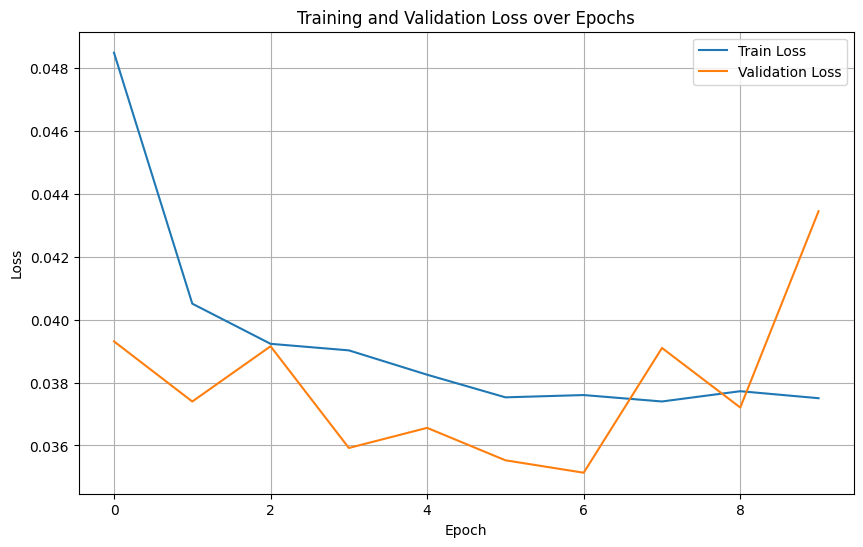

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

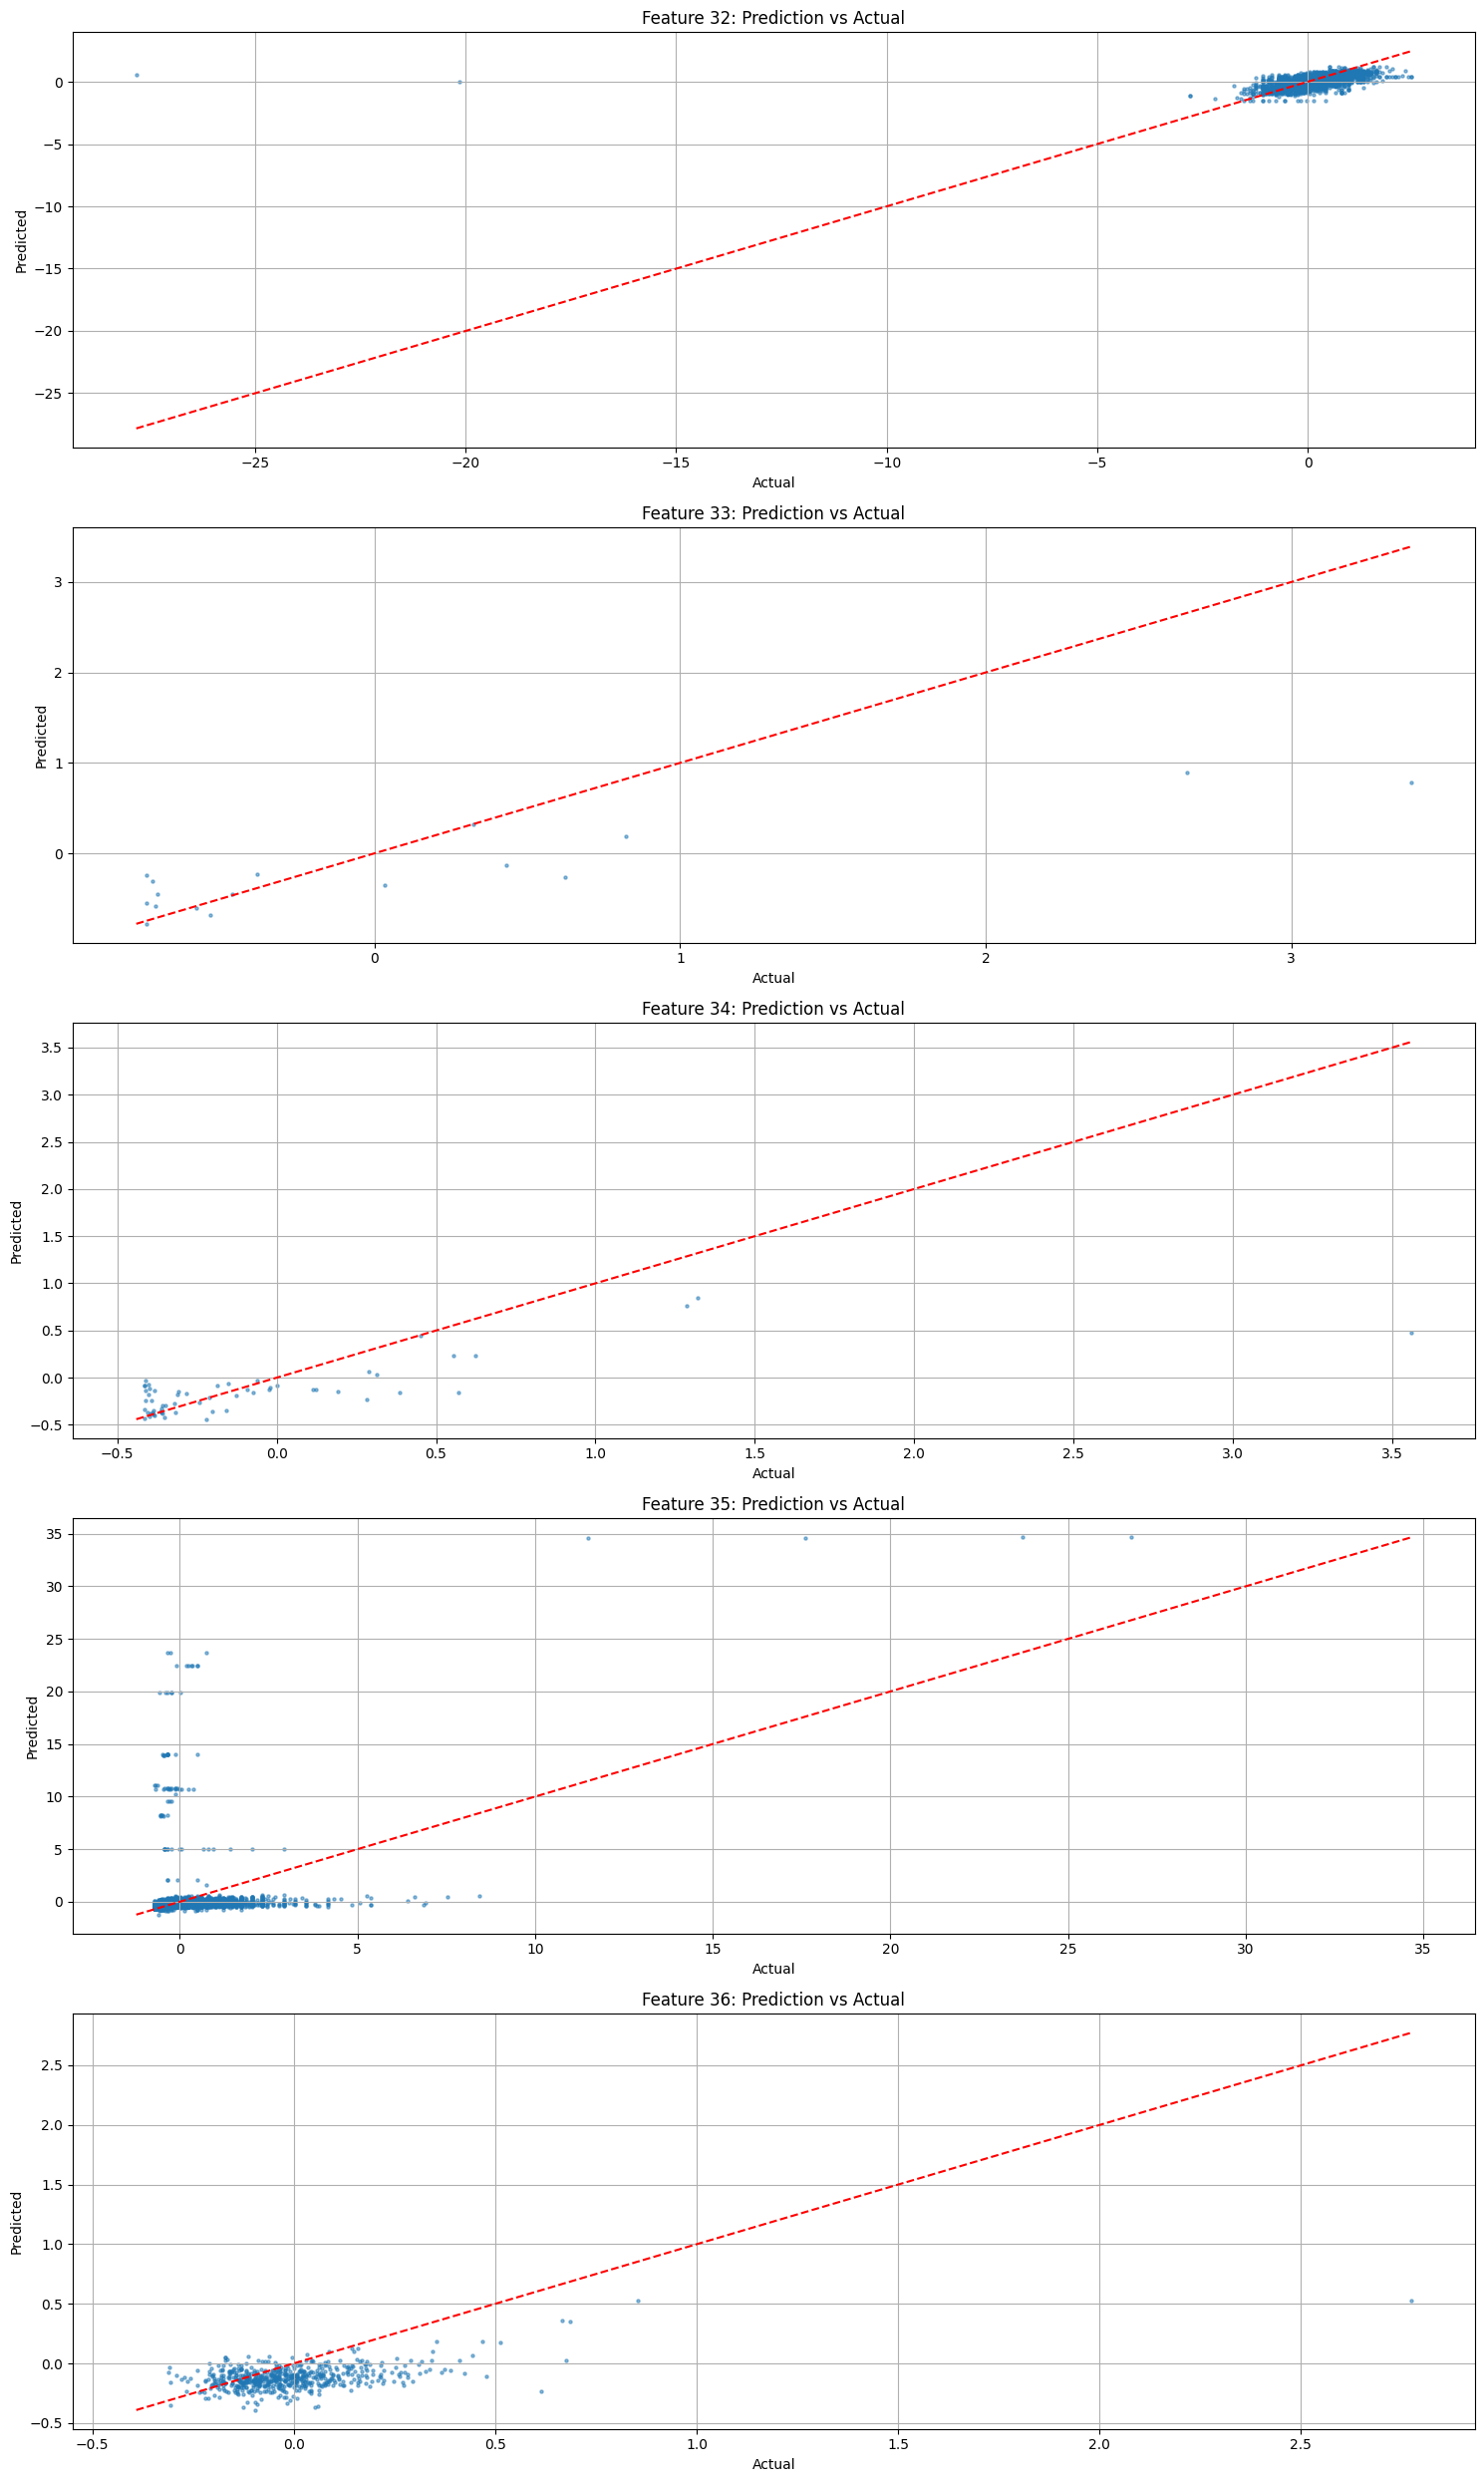

In [26]:
# Plotting prediction vs actual for a few features from the test set
# Selecting a few features to visualize (e.g., the last 5)
num_features_to_plot = min(5, preds.size(2)) # Don't plot more features than exist

# Flatten the batch and sequence length for easier plotting
preds_flat = preds.view(-1, preds.size(2))
tgts_flat = tgts.view(-1, tgts.size(2))
masks_flat = masks.view(-1, masks.size(2))

plt.figure(figsize=(15, 5 * num_features_to_plot))
for i in range(num_features_to_plot):
    plt.subplot(num_features_to_plot, 1, i + 1)
    # Select the i-th feature from the end's flattened predictions, targets, and masks
    feature_index = preds.size(2) - num_features_to_plot + i
    preds_feature_flat = preds_flat[:, feature_index]
    tgts_feature_flat = tgts_flat[:, feature_index]
    masks_feature_flat = masks_flat[:, feature_index]


    # Filter out padded values for the current feature using its mask
    preds_feature_observed = preds_feature_flat[masks_feature_flat.bool()]
    tgts_feature_observed = tgts_feature_flat[masks_feature_flat.bool()]

    if tgts_feature_observed.numel() > 0: # Only plot if there are observed values for this feature
        plt.scatter(tgts_feature_observed.numpy(), preds_feature_observed.numpy(), alpha=0.5, s=5)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Feature {feature_index+1}: Prediction vs Actual')
        # Add a line for perfect prediction
        min_val = min(tgts_feature_observed.min(), preds_feature_observed.min())
        max_val = max(tgts_feature_observed.max(), preds_feature_observed.max())
        plt.plot([min_val.numpy(), max_val.numpy()], [min_val.numpy(), max_val.numpy()], 'r--')
        plt.grid(True)
    else:
        plt.title(f'Feature {feature_index+1}: No observed values to plot')


plt.tight_layout()
plt.show()

Next Steps:
1. Review Code and See how to plot more datapoints per timestep
2. Complete Hyperparamter Testing to Find Better Loss Plot that shows a steady decreasing trend
3. Observe the code and see how to review more points in the forecasting and improve accuracy from R2 Score